In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
font = {'size'   : 16}
matplotlib.rc('font', **font)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
font = {'family' : 'serif',
        'serif':[],
        'weight' : 'bold',
        'size'   : 16}
rc('font', **font)
rc('text', usetex=True)
sns.set_style('white')
import splat
from splat import evolve
from splat import empirical
from tqdm import tqdm

%matplotlib inline

### Spectral types from M5 to L7

In [341]:
sptn = np.arange(13)+15
spt = [splat.typeToNum(x) for x in sptn]

### Get absolute magnitudes from Filippazzo et al. 2015

In [342]:
MJ = [empirical.typeToMag(spt,'2MASS J')[0] for spt in spt] #Default: Filippazzo et al. 2015
MJe = 0.4*np.ones(len(MJ))

In [343]:
MJ

[nan,
 10.081345279999999,
 10.701793459999996,
 11.127527039999999,
 11.459590219999997,
 11.767999999999992,
 12.095919779999983,
 12.463832959999989,
 12.873716539999998,
 13.313214719999975,
 13.759812499999969,
 14.185009279999997,
 14.558492459999966]

#### Add placeholder M5 MJ because Filippazzo et al. 2015 doesn't have it. This one comes from Mamajek's website

In [344]:
MJ[0] = 9.25

Text(0,0.5,'MJ')

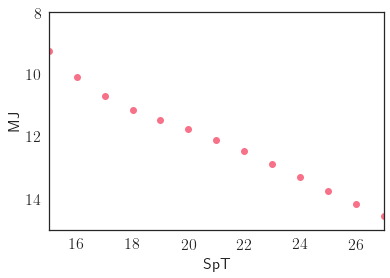

In [345]:
plt.plot(sptn,MJ,'o')
plt.xlim(15,27)
plt.ylim(15,8)
plt.xlabel('SpT',fontsize=16)
plt.ylabel('MJ',fontsize=16)

### Calculate the apparent magnitude limits at 25pc assuming the absolute magnitudes of an M7 and an L5. These are the apparent magnitudes an object misclassified as an M7 or L5 should have to be included in the sample, respectively.

In [492]:
magM7 = [mJ[2],MJ[2]]
magL5 = [mJ[10],MJ[10]]
magM7,magL5

([12.691493503360183, 10.701793459999996],
 [15.749512543360156, 13.759812499999969])

In [493]:
def appmag(absmag, d):
    return 5*np.log10(d/10) + absmag

In [494]:
d = 25
mJM7 = appmag(magM7[1],d)
mJL5 = appmag(magL5[1],d)

In [495]:
mJM7, mJL5

(12.691493503360183, 15.749512543360156)

### i.e. if an object has been misclassified as an M7 *and* has an apparent magnitude of 12.69 mag, then it will be included in the survey. What is its true distance? Depends on its spectral type and true absolute magnitude.

In [415]:
def distlim(appmag, absmag):
    return 10**((appmag - absmag)/5)*10

##### magdistM7 = the distance an object has if it has the same apparent magnitude as an M7 but it is misclassified
##### magdistL5 = the distance an object has if it has the same apparent magnitude as an L5 but it is misclassified

In [416]:
magdistM7 = distlim(mJM7, MJ)
magdistL5 = distlim(mJL5, MJ)

In [417]:
magdistM7, magdistL5

(array([ 48.78639196,  33.26822612,  25.        ,  20.54912305,
         17.63521086,  15.30025612,  13.15572373,  11.10534637,
          9.19507747,   7.51027357,   6.11415157,   5.02686063,   4.23253159]),
 array([ 199.48144646,  136.02960992,  102.22186887,   84.02279046,
          72.10816846,   62.56083097,   53.79210663,   45.40837043,
          37.59752014,   30.70856798,   25.        ,   20.55420353,
          17.30629159]))

#### These are the volumes corresponding to the limiting magnitude cuts per spectral subtype. Pack everything into a dataframe.

In [419]:
paramsdf = pd.DataFrame(index=np.arange(len(sptn)),columns=['sptn','MJ','mj','magdistM7','magdistL5'])
paramsdf['sptn'] = sptn
paramsdf['MJ'] = MJ
paramsdf['mj'] = mJ
paramsdf['maglimdistM7'] = magdistM7
paramsdf['maglimdistL5'] = magdistL5

#### paramsdf columns:
- sptn = numeric spectral type. M5 = 15, L0 = 20.  
- MJ = absolute magnitude in J band (from Filippazzo et al. 2015)  
- mj = apparent magnitude in J band at 25pc. 
- maglimdistM7 = distance the object would have if it had the same apparent magnitude as the limiting magnitude for M7
- maglimdistL5 = distance the object would have if it had the same apparent magnitude as the limiting magnitude for L5

In [432]:
paramsdf

,sptn,MJ,mj,maglimdistM7,maglimdistL5
0,15,9.250000,11.239700,48.786392,199.481446
1,16,10.081345,12.071045,33.268226,136.029610
2,17,10.701793,12.691494,25.000000,102.221869
3,18,11.127527,13.117227,20.549123,84.022790
4,19,11.459590,13.449290,17.635211,72.108168
5,20,11.768000,13.757700,15.300256,62.560831
6,21,12.095920,14.085620,13.155724,53.792107
7,22,12.463833,14.453533,11.105346,45.408370
8,23,12.873717,14.863417,9.195077,37.597520
9,24,13.313215,15.302915,7.510274,30.708568


### Simulate 10$^6$ sources per spectral subtype in new dataframe.
Assign:
- distances from a power law distribution of distances d$^3$ from 0 to 2x the magnitude-limited distance.
- absolute magnitudes from a normal distribution centered around MJ with plus/minus uncertainty and based on their spectral type.

In [433]:
niter = 1000000
cols=['sptn','distM7','distL5']
df = pd.DataFrame(index=np.arange(0),columns=cols)

In [434]:
for i in tqdm(np.arange(len(sptn))):
    subdf = pd.DataFrame(index=np.arange(niter),columns=cols)
    subdf['sptn'] = sptn[i]
    ddistM7 = np.random.power(3,size=niter)*magdistM7[i]*2
    ddistL5 = np.random.power(3,size=niter)*magdistL5[i]*2
    MJdist = np.random.normal(loc=paramsdf.loc[i,'MJ'], scale=0.4, size=niter)
    pick1 = (np.random.uniform(0,1,size=niter)*niter).astype(int)
    pick2 = (np.random.uniform(0,1,size=niter)*niter).astype(int)
    pick3 = (np.random.uniform(0,1,size=niter)*niter).astype(int)
    subdf['distM7'] = ddistM7[pick1]
    subdf['distL5'] = ddistL5[pick2] 
    subdf['MJ'] = MJdist[pick3]
    df = df.append(subdf)

100%|██████████| 13/13 [00:08<00:00,  1.58it/s]


In [554]:
df = df.reset_index()

In [435]:
df.columns

Index(['MJ', 'distL5', 'distM7', 'sptn'], dtype='object')

#### Calculate the apparent magnitude the misclassified objects would have if they are at the given distance, and given their own absolute magnitude

In [557]:
df['mjM7'] = maglim(df['MJ'],df['distM7'])
df['mjL5'] = maglim(df['MJ'],df['distL5'])

#### df columns:
- sptn = numeric spectral type of source. M5 = 15, L0 = 20.  
- MJ = randomly-assigned absolute magnitude in J band from a normal distribution centered around the median MJ for its SpT (from Filippazzo et al. 2015)  
- distM7 = randomly assigned distance from a power law distribution (d$^3$) running from 0 to 2x the distance an object misclassified as an M7 would have, given its apparent and absolute magnitudes.  
- distL5 = randomly assigned distance from a power law distribution (d$^3$) running from 0 to 2x the distance an object misclassified as an L5 would have, given its apparent and absolute magnitudes.

In [558]:
spt = [spt[i][0:2] for i in np.arange(len(spt))]

100%|██████████| 13/13 [00:32<00:00,  2.48s/it]


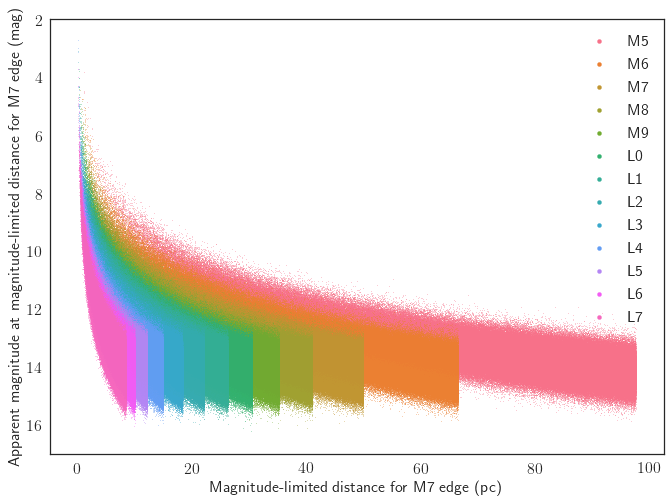

In [561]:
fig = plt.figure(figsize=(11,8))
sns.set_palette("husl",n_colors=13)
for i in tqdm(sptn):
    subdf = df.groupby('sptn').get_group(i)
    plt.scatter(subdf['distM7'],subdf['mjM7'],marker='o',s=0.1)
plt.xlabel('Magnitude-limited distance for M7 edge (pc)',fontsize=16)
plt.ylabel('Apparent magnitude at magnitude-limited distance for M7 edge (mag)',fontsize=16)
plt.legend(spt,markerscale=13,fontsize=16,loc=1)
plt.ylim(17,2)
plt.savefig("appmags_for_M7edge.jpg")

100%|██████████| 13/13 [00:33<00:00,  2.58s/it]


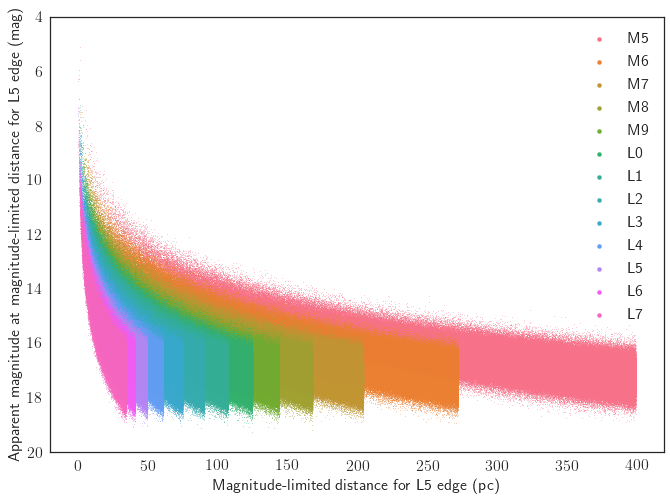

In [562]:
fig = plt.figure(figsize=(11,8))
sns.set_palette("husl",n_colors=13)
for i in tqdm(sptn):
    subdf = df.groupby('sptn').get_group(i)
    plt.scatter(subdf['distL5'],subdf['mjL5'],marker='o',s=0.1)
plt.xlabel('Magnitude-limited distance for L5 edge (pc)',fontsize=16)
plt.ylabel('Apparent magnitude at magnitude-limited distance for L5 edge (mag)',fontsize=16)
plt.legend(spt,markerscale=13,fontsize=16,loc=1)
plt.ylim(20,4)
plt.savefig("appmags_for_L5edge.jpg")

100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


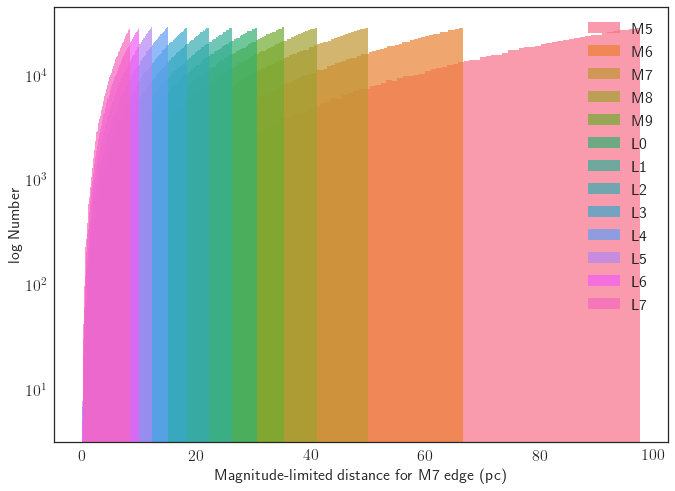

In [563]:
fig = plt.figure(figsize=(11,8))
sns.set_palette("husl",n_colors=13)
for i in tqdm(sptn):
    subdf = df.groupby('sptn').get_group(i)
    plt.hist(subdf['distM7'],bins=100,alpha=0.7,log=True)
plt.xlabel('Magnitude-limited distance for M7 edge (pc)',fontsize=16)
plt.ylabel('log Number',fontsize=16)
plt.legend(spt,markerscale=13,fontsize=16,loc=1)
plt.savefig("distance_histograms_for_M7edge.jpg")

100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


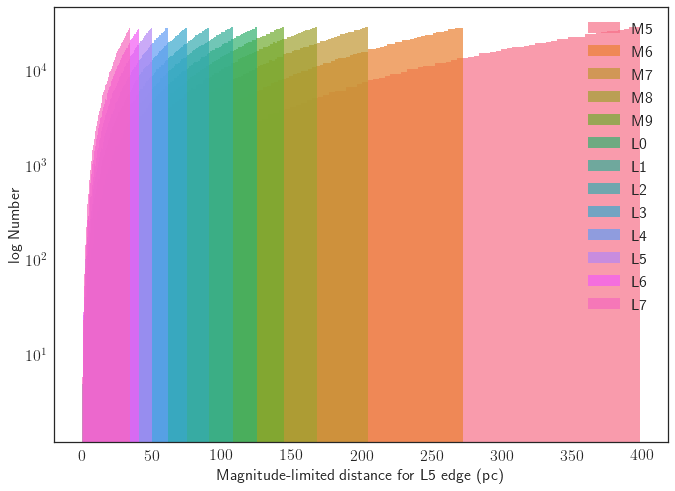

In [564]:
fig = plt.figure(figsize=(11,8))
sns.set_palette("husl",n_colors=13)
for i in tqdm(sptn):
    subdf = df.groupby('sptn').get_group(i)
    plt.hist(subdf['distL5'],bins=100,alpha=0.7,log=True)
plt.xlabel('Magnitude-limited distance for L5 edge (pc)',fontsize=16)
plt.ylabel('log Number',fontsize=16)
plt.legend(spt,markerscale=13,fontsize=16,loc=1)
plt.savefig("distance_histograms_for_L5edge.jpg")

### Cuts per spectral type on apparent magnitude of M7/L5

In [565]:
mJM7, mJL5

(12.691493503360183, 15.749512543360156)

In [566]:
df['M7_in/out'] = np.nan
df['L5_in/out'] = np.nan
outM7 = df[df['mjM7'] > mJM7]
inM7 = df[df['mjM7'] <= mJM7]
outM7['M7_in/out'] = 'out'
inM7['M7_in/out'] = 'in'
M7df = pd.concat([outM7,inM7])

In [567]:
len(outM7)+len(inM7), len(M7df)

(13000000, 13000000)

In [568]:
outL5 = M7df[M7df['mjL5'] > mJL5]
inL5 = M7df[M7df['mjL5'] <= mJL5]
outL5['L5_in/out'] = 'out'
inL5['L5_in/out'] = 'in'
finaldf = pd.concat([outL5,inL5])

In [569]:
len(outL5)+len(inL5), len(finaldf) 

(13000000, 13000000)

In [570]:
len(outM7)/len(finaldf), len(outL5)/len(finaldf)

(0.8544549230769231, 0.8543234615384615)

In [578]:
finaldf = finaldf.sort_index()

In [ ]:
for i in sptn:
    subdf = finaldf.groupby('sptn').get_group(i)

In [579]:
diff = np.where(finaldf['M7_in/out'] != finaldf['L5_in/out'])[0]

In [583]:
mJM7, mJL5, len(diff)

(12.691493503360183, 15.749512543360156, 3037111)

In [580]:
finaldf.loc[diff]

,index,MJ,distL5,distM7,sptn,mjM7,mjL5,M7_in/out,L5_in/out
1,1,8.927586,158.009467,76.151316,15,13.335973,14.921001,out,in
3,3,8.609744,171.507574,95.895564,15,13.518736,14.781160,out,in
6,6,9.081710,375.420861,17.083067,15,10.244539,16.954302,in,out
9,9,8.931275,217.115058,68.881531,15,13.121789,15.614725,out,in
11,11,8.616015,150.278622,95.551090,15,13.517194,14.500501,out,in
18,18,9.433403,135.269987,60.264550,15,13.333713,15.089411,out,in
22,22,10.268960,378.930332,29.335966,15,12.605962,18.161756,in,out
23,23,9.312461,369.077917,37.985867,15,12.210571,17.148051,in,out
24,24,9.456021,362.168144,31.893584,15,11.974538,17.250572,in,out
33,33,9.123644,151.141343,75.676351,15,13.518445,15.020561,out,in


In [ ]:
#### This means that, proportionally,
- XX% of objects are trickling into the sample on the M7 edge
- XX% of objects are trickling out of the sample on the M7 edge
- XX% of objects are trickling into the sample on the L5 edge
- XX% of objects are trickling out of the sample on the L5 edge

### Find number densities per subtype from Reid et al. 2008 and Cruz et al. 2007

In [458]:
reid08tab2 = pd.read_csv('/Users/daniella/Research/Relations/Reid2008_table2_oldUCD.txt',comment='#',sep=';')
reid08tab2 = reid08tab2.replace(' ',np.nan)
reid08tab3 = pd.read_csv('/Users/daniella/Research/Relations/Reid2008_table3_newUCD.txt',comment='#',sep=';')
reid08tab3['SpT'] = reid08tab3['SpT'].map(lambda x: x.strip())      

In [459]:
tab2 = reid08tab2[['2MASS','Jmag','SpT','n_SpT','Dist','n_Dist']]
tab3 = reid08tab3[['2MASS','Jmag','SpT','n_SpT','Dist','n_Dist']]
reid08 =  pd.concat([tab2,tab3],axis=0).reset_index()
reid08 = reid08.replace([' ',''],np.nan) 
reid08['sptn'] = reid08['SpT'].map(lambda x: np.round(splat.typeToNum(x),0))

In [460]:
reid08['sptn'].sort_values().unique()

array([ 16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
        27.,  28.,  30.,  nan])

In [461]:
grouped = reid08.groupby('sptn')
vol = (4*np.pi/3)*20**3*0.63 #pc^3
reid08dens = []
reid08densunc = []
r08 = pd.DataFrame(index=np.arange(13),columns=['sptn','density'])
for i in np.arange(13)+16:
    num = len(grouped.get_group(name=i))
    reid08dens = np.append(reid08dens,num/vol)
    reid08densunc = np.append(reid08densunc,np.sqrt(num)/vol)

r08['density'] = reid08dens
r08['sptn'] = np.arange(16,29)
r08['density_unc'] = reid08densunc

In [462]:
cruz07 = pd.read_csv('/Users/daniella/Research/Relations/Cruz2007_table910_LF.txt',comment='#',sep=';')
cruz07['SpType'] = cruz07['SpType'].map(lambda x: x.strip())
cruz07['sptn'] = cruz07['SpType'].map(lambda x: np.round(splat.typeToNum(x),0))

grouped = cruz07.groupby('sptn')
vol = (4*np.pi/3)*20**3*0.36 #pc^3
cruz07dens = []
cruz07densunc = []
c07 = pd.DataFrame(index=np.arange(12),columns=['sptn','density'])
for i in np.arange(17,29):
    num = len(grouped.get_group(name=i))
    cruz07dens = np.append(cruz07dens,num/vol)
    cruz07densunc = np.append(cruz07densunc,np.sqrt(num)/vol)

c07['density'] = cruz07dens
c07['sptn'] = np.arange(17,29)
c07['density_unc'] = cruz07densunc

In [473]:
kirk12 = pd.read_csv('/Users/daniella/Research/Relations/kirkpatrick2012_tab4.txt',comment='#',sep=';')
kirk12 = kirk12.replace(['      ','     ','         '],np.nan)
kirk12['SpT'] = kirk12['SpT'].map(lambda x: x.strip()) 
kirk12['sptn'] = kirk12['SpT'].map(lambda x: np.round(splat.typeToNum(x)))

grouped = kirk12.groupby('sptn')
vol = (4*np.pi/3)*8**3 #pc^3                    
kirk12dens = []
kirk12densunc = []
k12 = pd.DataFrame(index=np.arange(13),columns=['sptn','density'])
for i in np.arange(15,28):
    if i in list(kirk12['sptn']):
        num = len(grouped.get_group(name=i))
        kirk12dens = np.append(kirk12dens,num/vol)
        kirk12densunc = np.append(kirk12densunc,np.sqrt(num)/vol)
    else:
        kirk12dens = np.append(kirk12dens,np.nan)
        kirk12densunc = np.append(kirk12densunc,np.nan)
        
k12['sptn'] = np.arange(15,28)        
k12['density'] = kirk12dens
k12['density_unc'] = kirk12densunc

In [474]:
k12

,sptn,density,density_unc
0,15,0.006994,0.001806
1,16,0.010724,0.002236
2,17,0.001399,0.000808
3,18,0.002331,0.001043
4,19,0.000933,0.000659
5,20,0.000466,0.000466
6,21,NaN,NaN
7,22,NaN,NaN
8,23,NaN,NaN
9,24,NaN,NaN


In [475]:
paramsdf['C07dens'] = np.nan
paramsdf['R08dens'] = np.nan
paramsdf['K12dens'] = np.nan
paramsdf['C07dens_unc'] = np.nan
paramsdf['R08dens_unc'] = np.nan
paramsdf['K12dens_unc'] = np.nan

paramsdf.loc[2:,'C07dens'] = c07.loc[:10,'density'].values
paramsdf.loc[1:,'R08dens'] = r08.loc[:11,'density'].values
paramsdf['K12dens'] = k12['density'].values
paramsdf.loc[2:,'C07dens_unc'] = c07.loc[:10,'density_unc'].values
paramsdf.loc[1:,'R08dens_unc'] = r08.loc[:11,'density_unc'].values
paramsdf['K12dens_unc'] = k12['density_unc'].values

In [476]:
def vol(r):
    return 4/3*np.pi*r**3

In [477]:
paramsdf['NsourcesM7_R08'] = paramsdf['C07dens']*vol(paramsdf['maglimdistM7'])
paramsdf['NsourcesM7_C07'] = paramsdf['R08dens']*vol(paramsdf['maglimdistM7'])
paramsdf['NsourcesM7_K12'] = paramsdf['K12dens']*vol(paramsdf['maglimdistM7'])
paramsdf['NsourcesL5_R08'] = paramsdf['C07dens']*vol(paramsdf['maglimdistL5'])
paramsdf['NsourcesL5_C07'] = paramsdf['R08dens']*vol(paramsdf['maglimdistL5'])
paramsdf['NsourcesL5_K12'] = paramsdf['K12dens']*vol(paramsdf['maglimdistL5'])

paramsdf['NuncM7_R08'] = np.sqrt(paramsdf['NsourcesM7_R08'])/vol(paramsdf['maglimdistM7'])
paramsdf['NuncM7_C07'] = np.sqrt(paramsdf['NsourcesM7_C07'])/vol(paramsdf['maglimdistM7'])
paramsdf['NuncM7_K12'] = np.sqrt(paramsdf['NsourcesM7_K12'])/vol(paramsdf['maglimdistM7'])
paramsdf['NuncL5_R08'] = np.sqrt(paramsdf['NsourcesL5_R08'])/vol(paramsdf['maglimdistL5'])
paramsdf['NuncL5_C07'] = np.sqrt(paramsdf['NsourcesL5_C07'])/vol(paramsdf['maglimdistL5'])
paramsdf['NuncL5_K12'] = np.sqrt(paramsdf['NsourcesL5_K12'])/vol(paramsdf['maglimdistL5'])

In [478]:
paramsdf

,sptn,MJ,mj,maglimdistM7,maglimdistL5,C07dens,R08dens,C07dens_unc,R08dens_unc,NsourcesM7_R08,...,NuncM7_R08,NuncM7_C07,NuncL5_R08,NuncL5_C07,K12dens,K12dens_unc,NsourcesM7_K12,NsourcesL5_K12,NuncM7_K12,NuncL5_K12
0,15,9.250000,11.239700,48.786392,199.481446,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.006994,0.001806,3401.867546,232556.682847,0.000120,0.000015
1,16,10.081345,12.071045,33.268226,136.029610,NaN,0.000095,NaN,0.000067,NaN,...,NaN,0.000025,NaN,0.000003,0.010724,0.002236,1654.043051,113072.822496,0.000264,0.000032
2,17,10.701793,12.691494,25.000000,102.221869,0.001078,0.000095,0.000299,0.000067,70.529514,...,0.000128,0.000038,0.000016,0.000005,0.001399,0.000808,91.552734,6258.679952,0.000146,0.000018
3,18,11.127527,13.117227,20.549123,84.022790,0.003730,0.000947,0.000556,0.000212,135.581334,...,0.000320,0.000161,0.000039,0.000020,0.002331,0.001043,84.738334,5792.837493,0.000253,0.000031
4,19,11.459590,13.449290,17.635211,72.108168,0.000995,0.000853,0.000287,0.000201,22.852343,...,0.000208,0.000193,0.000025,0.000023,0.000933,0.000659,21.424071,1464.581111,0.000201,0.000024
5,20,11.768000,13.757700,15.300256,62.560831,0.000663,0.000568,0.000234,0.000164,9.949325,...,0.000210,0.000195,0.000025,0.000024,0.000466,0.000466,6.995619,478.230824,0.000176,0.000021
6,21,12.095920,14.085620,13.155724,53.792107,0.000497,0.000237,0.000203,0.000106,4.743545,...,0.000228,0.000158,0.000028,0.000019,NaN,NaN,NaN,NaN,NaN,NaN
7,22,12.463833,14.453533,11.105346,45.408370,0.000829,0.000379,0.000262,0.000134,4.755584,...,0.000380,0.000257,0.000046,0.000031,NaN,NaN,NaN,NaN,NaN,NaN
8,23,12.873717,14.863417,9.195077,37.597520,0.000414,0.000237,0.000185,0.000106,1.349720,...,0.000357,0.000270,0.000043,0.000033,NaN,NaN,NaN,NaN,NaN,NaN
9,24,13.313215,15.302915,7.510274,30.708568,0.000580,0.000379,0.000219,0.000134,1.029610,...,0.000572,0.000462,0.000069,0.000056,NaN,NaN,NaN,NaN,NaN,NaN


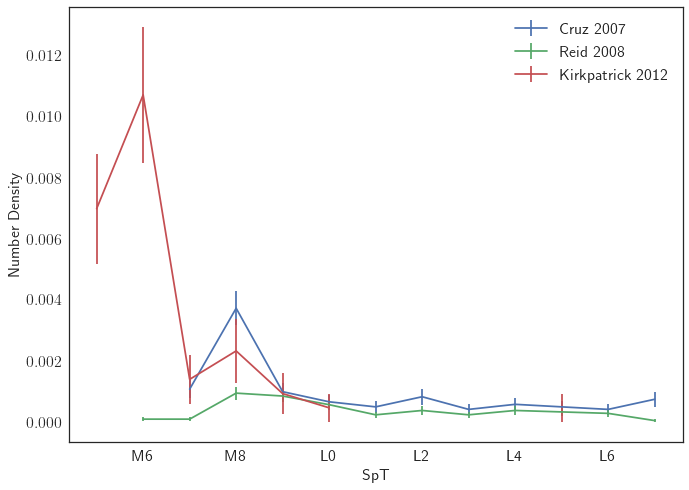

In [481]:
sns.set_palette("deep")
fig = plt.figure(figsize=(11,8))
plt.errorbar(paramsdf['sptn'],paramsdf['C07dens'],yerr=paramsdf['C07dens_unc'])
plt.errorbar(paramsdf['sptn'],paramsdf['R08dens'],yerr=paramsdf['R08dens_unc'])
plt.errorbar(paramsdf['sptn'],paramsdf['K12dens'],yerr=paramsdf['K12dens_unc'])
plt.legend(['Cruz 2007','Reid 2008','Kirkpatrick 2012'],fontsize=16)
plt.xlabel('SpT',fontsize=16)
plt.ylabel('Number Density',fontsize=16)
plt.xticks(np.arange(16,28,2),['M6','M8','L0','L2','L4','L6'],fontsize=16)
plt.savefig("number_densities_comparison.jpg")

#### Find proportion of objects missed by magnitude cut